In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

fd = {'size':16, 'family':'serif'} # font dictionary (settings) for plotting

In [3]:
##
## Parameters for training and assessment
##

# We will vary these and see how well we train and (over)fit
d = None # number of dimensions (features) after pre-processing
N = None # number of datapoints in each class (ie: top, bottom) -- 2*N == # of training points

features = None # the training set, determined based on N
test_features = None # the out-sample dataset, we will always use the last 5000 elements

theta = None # the weights we will be fitting

In [24]:
##
##  Load Data
##
imgs = np.reshape(np.load('imgs.npy'), (-1, 28, 28))/256.0
lbls =            np.load('lbls.npy')               
print('loaded {} many {}-by-{} images'.format(*imgs.shape))
print('loaded {} many labels'         .format(*lbls.shape))

loaded 60000 many 28-by-28 images
loaded 60000 many labels


In [5]:
##
## Mapping lbls from numbers to their English meaning
##

# Note each of these is a vector of true/false values of height 60,000!
tees     = (lbls==0)
trousers = (lbls==1)
pullovers= (lbls==2)
dresses  = (lbls==3)
coats    = (lbls==4)
sandals  = (lbls==5)
shirts   = (lbls==6)
sneakers = (lbls==7)
bags     = (lbls==8)
boots    = (lbls==9)

bottoms = sandals | boots | sneakers | trousers 
tops    = tees | pullovers | shirts | coats | dresses

shape is: (28, 28)
label is: 7


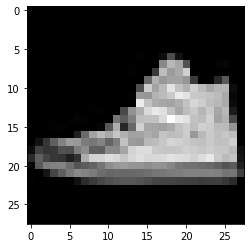

In [105]:
##
## Visual Inspection of the data
##

cls = sneakers
idx = 14
print(f"shape is: {imgs[cls][idx].shape}")
print(f"label is: {lbls[cls][idx]}")
plt.imshow(imgs[cls][idx], cmap='gray') # indicates greyscale, not rgb

In [120]:
##
## Precompute some Relevant Values from Image Processing
##
avg_bright = lambda arr: np.mean(np.abs(arr), axis=(1,2))
max_bright = lambda arr: np.max(np.abs(arr), axis=(1,2))
intensities = avg_bright(imgs               )                   # average pixel brightness
diversities = avg_bright(imgs*imgs          ) - intensities**2  # variance in pixel brightness
bottom_seps = avg_bright(imgs[:,14:,12:16]  )                   # average brightness in bottom half, middle 1/7
edge_amount = max_bright(imgs[:,:,:4])+max_bright(imgs[:,:,24:])# amount of stuff at edge
asymmetries = avg_bright(imgs-imgs[:,:,::-1]) / (2*intensities) # average difference of left-right reflection, normalized by intensity
antigravity = avg_bright(imgs[:,:14,:]      )                   # average brightness of top half
backgrounds = avg_bright(imgs < 0.01        )                   # percentage of image that is dim

In [121]:
##
## Plotting functions
##

styles = {
    'red':  {'marker':'+', 'c':'red', 's':60},
    'blue': {'marker':'x', 'c':'blue','s':30},
}

def plot_data(N, clothes, x_axis, y_axis, text, color):
    '''
    Generate x-y plot of all images against 2 features
    '''
    X, Y = x_axis[clothes][:N], y_axis[clothes][:N]
    plt.scatter(X, Y, **styles[color])
    plt.text(0.9-len(text)*0.02, np.mean(Y)+0.05, text, color=color, fontdict=fd)

def plot_class(db=True):
    X, Y = np.meshgrid(
        np.linspace(0.0,+1.0, 500),
        np.linspace(0.0,+1.0, 500),
    )
    Y = 1.0-Y
    Z = np.stack(preprocess(X,Y), axis=2)
    Z = classify(Z)
    if db:
        Z = np.sign(Z)
    Z = np.maximum(-3.0, np.minimum(3.0, Z))

    fadedness = 8.0 if db else 16.0
    plt.imshow(Z, interpolation='nearest', extent=(0,1,0,1),
               cmap='coolwarm', vmin=-fadedness, vmax=+fadedness)

def save_plot(file_name):
    plt.xticks([])
    plt.yticks([])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    plt.xlabel('percent background', fontdict=fd)
    plt.ylabel('asymmetry', fontdict=fd)
    plt.gca().set_aspect('equal')
    plt.gcf().set_size_inches(5.0, 5.0)
    plt.tight_layout()
    
    plt.savefig(file_name)
    plt.clf()

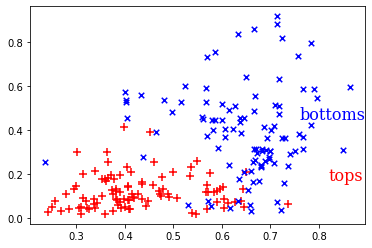

In [126]:
N = 100
plot_data(N, tops    , backgrounds, asymmetries, 'tops', 'red')
plot_data(N, bottoms , backgrounds, asymmetries, 'bottoms', 'blue')

In [127]:
##
## Classification and Measurement Functions
##

def classify(data):
    '''
    linear classifier -- multiply the i'th feature by the i'th weight (theta) and sum
    '''
    return np.dot(data, theta)

def badness(test=False):
    '''
    Count mean error of classification:
    - distance of estiamte away from tops for tops
    - distance of estimate away from bottoms for bottoms
    '''
    ff = test_features if test else features
    return (  np.sum(np.maximum(0.0, +1.0 - classify(ff['tops'])))
            + np.sum(np.maximum(0.0, +1.0 + classify(ff['bottoms'  ]))) )/sum(map(len, ff.values()))

def accuracy(test=False):
    '''
    Count how many classifications are correct
    '''
    ff = test_features if test else features
    return (  np.sum(np.abs(classify(ff['tops'])>0.0))
            + np.sum(np.abs(classify(ff['bottoms'])<0.0)) )/sum(map(len, ff.values()))

def squeaky(tt):
    '''
    Squeak the weights towards lower badness
    '''
    return (  np.sum(features['tops'][classify(features['tops']) < +1.0], axis=0)
            - np.sum(features['bottoms'][classify(features['bottoms']) > -1.0], axis=0) )/(2*N)

def preprocess(x,y):
    '''
    Generate a list of n-term products of x and y, up to 28 entries.
    x,y are vectors where the i'th entry is a feature of the i'th image.
    
    this generates features that <= log_2(d) degree polynomials in our 2 features.
    '''
    x = 4*x-2
    y = 4*y-2
    #x = 3*x-1.5
    #y = 3*y-1.5
    return (
        1.0+0*x,                                     # vector of 1's
        y, x,                                        # products with 1 term
        x*x, x*y, y*y,                               # products with 2 terms
        x*x*x, x*x*y, x*y*y, y*y*y,                  # products with 3 terms
        x*x*x*x, x*x*x*y, x*x*y*y, x*y*y*y, y*y*y*y, # ...
        x*x*x*x*x, x*x*x*x*y, x*x*x*y*y, x*x*y*y*y, x*y*y*y*y, y*y*y*y*y,
        x*x*x*x*x*x, x*x*x*x*x*y, x*x*x*x*y*y, x*x*x*y*y*y, x*x*y*y*y*y, x*y*y*y*y*y, y*y*y*y*y*y
    )[:d]

In [128]:
##
## Running Training over Parameters
##



for NN in [2,8,16,64]:
    N = NN
    print('N =',N)

    dds = list(range(1,28+1,3)) if N in (8,16) else [2,6,10,28]
    tests = []
    bads = []
    trains = []
    for dd in dds:
        d = dd

        badnesses = []
        err_trains = []
        err_tests = []
        
        nb_trials_per_condition = 2 #(10 if N==8 else 1)
        
        for offset in range(0,100 * nb_trials_per_condition,100):
            print('.', end='', flush=True)
            features = {
                'tops':  np.array([ preprocess(x,y) for x,y in zip(backgrounds[tops  ][offset:][:N], asymmetries[tops  ][offset:][:N])]),
                'bottoms':np.array([preprocess(x,y) for x,y in zip(backgrounds[bottoms][offset:][:N], asymmetries[bottoms][offset:][:N])]),
            }
            TEST = 5000
            test_features = {
                'tops':  np.array([ preprocess(x,y) for x,y in zip(backgrounds[tops  ][-TEST:], asymmetries[tops  ][-TEST:])]),
                'bottoms':np.array([preprocess(x,y) for x,y in zip(backgrounds[bottoms][-TEST:], asymmetries[bottoms][-TEST:])]),
            }
    
            steps = []
            badnesses_inner = []
            err_trains_inner = []
            err_tests_inner = []
 
            theta = np.zeros(len(preprocess(0,0)))
            step = 0
            while step != 10000:
                
                # v   v   v   v   v   v   v   v
                
                theta = theta + 0.01 * squeaky(theta)
                
                # ^   ^   ^   ^   ^   ^   ^   ^                  
                #  Above is optimizatation's key idea!           
                #  We take a *tiny* step (proportional to 0.01)  
                #  in a *good* direction (squeaky)               
                #________________________________________________
                
                # the rest is just measurement and plotting code...
                
                step += 1
                
                if step % 200 and step not in [10,100, 1,2,4,16,64,256]: continue
            
                bb = badness()
                e_train = 1.0 - accuracy()
                e_test  = 1.0 - accuracy(test=True)
            
                steps.append(step)
                badnesses_inner.append(bb)
                err_trains_inner.append(e_train)
                err_tests_inner.append(e_test)
            
                if offset: continue 
                if step not in [1, 10, 100, 10000]: continue
                if (d,N) not in ((2,2), (2, 64), (10,16), (28,2), (28, 64)): continue
            
                verbose=False
                if verbose:
                    print('badness {:6.2f}% ... test err {:3.0f}% ... theta {:s}'.format(
                        100*bb, 100*e_test, ' '.join('{:+5.2f}'.format(xx) for xx in theta)
                    ))
            
                for db in [True, False]:
                    plot_data(N, tops  ,  backgrounds, asymmetries, 'tops', 'red')
                    plot_data(N, bottoms, backgrounds, asymmetries, 'bottoms', 'blue')
                    plot_class(db)
                    plt.text(0.02, 0.88, 'after {:3d} steps\ntest acc {:.0f}%'.format(
                        step, 100*(1.0-e_test)), fontdict=fd)
                    save_plot('z-{:02d}-{:04d}-{:s}-{:02d}.png'.format(d, N, ['soft','hard'][db], step))

            badnesses.append(badnesses_inner)
            err_trains.append(err_trains_inner)
            err_tests.append(err_tests_inner)

        badnesses = np.mean(np.array(badnesses), axis=0)   #+ 0.001 
        err_trains = np.mean(np.array(err_trains), axis=0) #+ 0.001 
        err_tests = np.mean(np.array(err_tests), axis=0)   #+ 0.001 
        print('    d = {: 3d}'.format(d),
              '  badness={:3.0f}%'.format(100*badnesses[-1]),
              '  trn err={:3.0f}%'.format(100*err_trains[-1]),
              '  tst err={:3.0f}%'.format(100*err_tests[-1]))
            
        bads.append(badnesses[-1])
        trains.append(err_trains[-1])
        tests.append(err_tests[-1])

        #if N != 8 or d not in (3,6,10,15,21,28): continue
        steps = np.array(steps)

        plt.plot(steps, err_tests , c='blue')
        plt.plot(steps, err_trains, c='red')
        plt.plot(steps, badnesses , c='orange')

        best_val, best_idx = min((v,i) for i,v in enumerate(err_tests))
        plt.plot([steps[best_idx], max(steps)     ], [best_val, best_val], c='blue', linestyle='dashed')
        plt.plot([steps[best_idx], steps[best_idx]], [0.0     , best_val], c='blue', linestyle='dashed')

        plt.xscale('log')
        plt.xlim([1, max(steps)])

        plt.ylim([0.0, 0.15])
        plt.yticks([0.0, 0.1])

        plt.ylabel('error', fontdict=fd)
        plt.xlabel('(log) number of optimization updates', fontdict=fd)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)

        plt.tight_layout()
        plt.savefig('z-vs-t-{:02d}-{:04d}.png'.format(d,N))
        plt.clf()

    DDS = dds
    tests = np.array(tests) 
    trains= np.array(trains)
    bads  = np.array(bads ) 
    
    plt.plot(DDS, trains, c='red')
    plt.plot(DDS, tests, c='blue')
    plt.plot(DDS, bads, c='orange')
    
    best_val, best_idx = min((v,i) for i,v in enumerate(tests))
    plt.plot([DDS[best_idx], max(DDS)],      [best_val, best_val], c='blue', linestyle='dashed')
    plt.plot([DDS[best_idx], DDS[best_idx]], [0.0, best_val],      c='blue', linestyle='dashed')
    
    plt.ylim([0.0, 0.15])
    plt.yticks([0.0, 0.1])
    plt.xticks(([1,3,6,10,15,21,28]))
    plt.ylabel('error', fontdict=fd)
    plt.xlabel('data dimension after preprocessing', fontdict=fd)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('z-vs-dim-{:04d}.png'.format(N))
    plt.clf()

N = 2
..

KeyboardInterrupt: 

<Figure size 360x360 with 0 Axes>

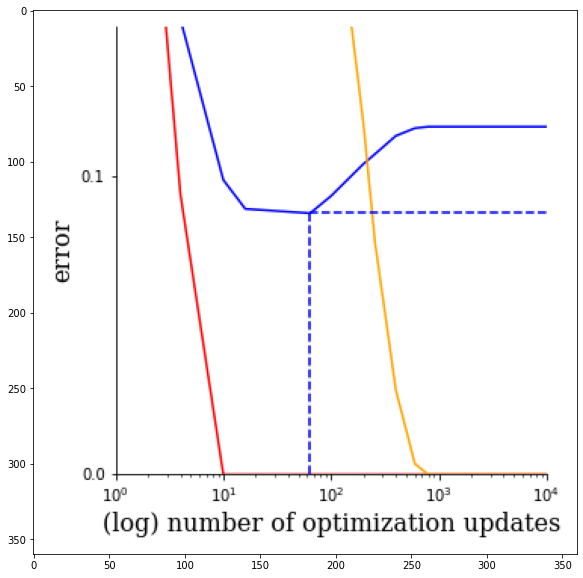

In [81]:
img = mpimg.imread('z-vs-t-28-0008.png')
plt.gcf().set_size_inches(10,10)
plt.imshow(img)

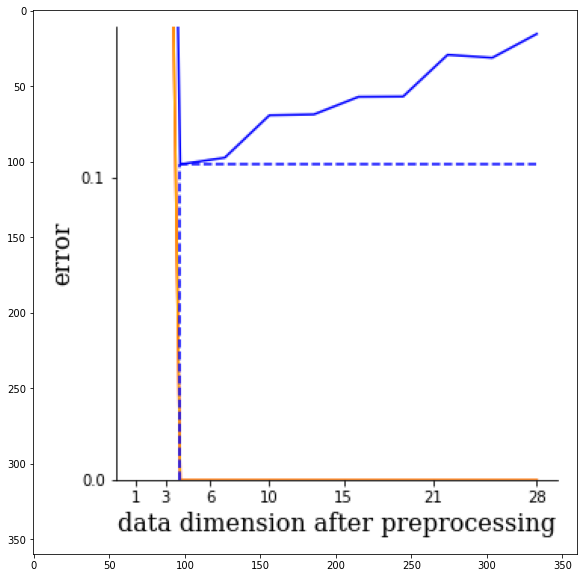

In [67]:
img = mpimg.imread('z-vs-dim-0008.png')
plt.gcf().set_size_inches(10,10)
plt.imshow(img)